In [1]:
import slax as sl
import flax.linen as nn
import jax.numpy as jnp
import jax
import optax
import pickle
from jax.tree_util import tree_map, Partial, tree_leaves, tree_structure, tree_unflatten
import matplotlib.pyplot as plt

In [2]:
input_sz = 64
output_sz = 10
seq_len = 20
manifold_key = jax.random.PRNGKey(0)
random_seed = manifold_key
key = manifold_key
batch_sz = 32
dtype = jnp.float32
n_steps = 5000

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


Metal device set to: Apple M3 Max

systemMemory: 48.00 GB
maxCacheSize: 18.00 GB



2024-05-11 15:08:28.155347: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


In [3]:
batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,dtype=dtype)

In [4]:
snn = sl.connect([nn.Dense(50),
                  sl.LIF(),
                  nn.Dense(50),
                  sl.LIF(),
                  nn.Dense(10),
                  sl.LIF()],cat={4:[1,2],2:[3]})

In [5]:
fsnn = sl.connect([nn.Dense(50),
                  sl.LIF(),
                  nn.Dense(50),
                  sl.LIF(),
                  nn.Dense(10),
                  sl.LIF()])

In [6]:
OSTL_snn = sl.connect([sl.DenseOSTL([nn.Dense(50),
                  sl.LIF()]),
                  sl.DenseOSTL([nn.Dense(10),
                  sl.LIF()])])

In [7]:
OTTT_snn = sl.connect([sl.OTTT([nn.Dense(50),
                  sl.LIF()],nn.sigmoid(2.)),
                  sl.OTTT([nn.Dense(10),
                  sl.LIF()],nn.sigmoid(2.))])

In [8]:
OTPE_snn = sl.connect([sl.DenseOTPE([nn.Dense(50),
                  sl.LIF()],nn.sigmoid(2.)),
                  sl.DenseOSTL([nn.Dense(10),
                  sl.LIF()])])

In [9]:
RTRL_snn = sl.connect([sl.RTRL([sl.connect([nn.Dense(50),
                  sl.LIF(),
                  nn.Dense(10),
                  sl.LIF()])])])

In [10]:
RTRL_snn = sl.RTRL([sl.flax_wrapper(nn.LSTMCell(100)),
                  sl.flax_wrapper(nn.LSTMCell(100))])

In [11]:
bp_model = snn
bp_params = bp_model.init(key,jnp.zeros_like(batch[0][0]))

In [13]:
map_abs = Partial(jax.tree_map,jnp.abs)

In [14]:
fsnn_params = fsnn.init(key,jnp.zeros_like(batch[0][0]))

In [15]:
out = bp_model.apply(bp_params,jnp.ones_like(batch[0][0])*0.1)
bp_params['carry'] = out[1]['carry']
out = bp_model.apply(bp_params,jnp.ones_like(batch[0][0]))

In [16]:
out2 = fsnn.apply(fsnn_params,jnp.ones_like(batch[0][0])*0.1)
fsnn_params['carry'] = out2[1]['carry']
out2 = fsnn.apply(fsnn_params,jnp.ones_like(batch[0][0]))

In [17]:
out[1]['carry']['chain_5']

{'Vmem': Array([[-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0.82396656, -0.07997465, -0.6605761 , -0.14384636],
        [-1.3568206 , -0.6138625 ,  0.45327306, -0.16069975, -0.5415852 ,
          0.15478146, -0

In [18]:
out2[1]['carry']['chain_5']

{'Vmem': Array([[ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0.500194  , -0.21611977,  0.03118493,  0.02742525],
        [ 0.15025353,  0.1505427 , -0.2932007 ,  0.0102549 , -0.29236132,
          0.46577865, -0

In [ ]:
ostl_model = OSTL_snn
ostl_params = ostl_model.init(key,jnp.zeros_like(batch[0][0]))
ostl_params['params'] = tree_unflatten(tree_structure(ostl_params['params']),tree_leaves(bp_params['params']))

In [13]:
ottt_model = OTTT_snn
ottt_params = ottt_model.init(key,jnp.zeros_like(batch[0][0]))
ottt_params['params'] = tree_unflatten(tree_structure(ottt_params['params']),tree_leaves(bp_params['params']))

In [14]:
otpe_model = OTPE_snn
otpe_params = otpe_model.init(key,jnp.zeros_like(batch[0][0]))
otpe_params['params'] = tree_unflatten(tree_structure(otpe_params['params']),tree_leaves(bp_params['params']))

In [21]:
rtrl_model = RTRL_snn
rtrl_params = rtrl_model.init(key,jnp.zeros_like(batch[0][0]))
#rtrl_params['params'] = tree_unflatten(tree_structure(rtrl_params['params']),tree_leaves(bp_params['params']))

In [23]:
rtrl_model.apply(rtrl_params,batch[0][0],mutable='carry')

(Array([[-0.00301379,  0.00132014,  0.00896563, ...,  0.00045912,
         -0.00545148, -0.00463615],
        [ 0.00603236,  0.01455439, -0.00132774, ..., -0.00411444,
         -0.00999687,  0.00389041],
        [-0.00647496, -0.00587156,  0.01597237, ..., -0.00028617,
          0.0005534 , -0.0096674 ],
        ...,
        [ 0.01368357,  0.00728739, -0.00122006, ...,  0.00808159,
         -0.02338879,  0.00286582],
        [-0.01555959,  0.00109154, -0.00305252, ..., -0.0110105 ,
          0.01809607, -0.0009359 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 {'carry': {'model_0': {'E': Array([[[0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            ...,
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.],
            [0., 0., 0., ..., 0., 0., 0.]],
    
           [[0., 0., 0., ..., 0., 0., 0.],
         

In [32]:
fptt_params = bp_params

In [33]:
optimizer = optax.adamax(0.01)
bp_opt_state = optimizer.init(tree_map(jnp.float32,bp_params['params']))
ostl_opt_state = optimizer.init(tree_map(jnp.float32,ostl_params['params']))
ottt_opt_state = optimizer.init(tree_map(jnp.float32,ottt_params['params']))
otpe_opt_state = optimizer.init(tree_map(jnp.float32,otpe_params['params']))
rtrl_opt_state = optimizer.init(tree_map(jnp.float32,rtrl_params['params']))
fptt_opt_state = optimizer.init(tree_map(jnp.float32,fptt_params['params']))

In [34]:
bp_train = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)
ostl_train = sl.train_online(ostl_model,optax.softmax_cross_entropy,optimizer)
ottt_train = sl.train_online(ottt_model,optax.softmax_cross_entropy,optimizer)
otpe_train = sl.train_online(otpe_model,optax.softmax_cross_entropy,optimizer)
rtrl_train = sl.train_online(rtrl_model,optax.softmax_cross_entropy,optimizer)
fptt_train = sl.FPTT(bp_model,optax.softmax_cross_entropy,optimizer)


bp_eval = sl.train_offline(bp_model,optax.softmax_cross_entropy,optimizer)
ostl_eval = sl.train_online_deferred(ostl_model,optax.softmax_cross_entropy,optimizer)
ottt_eval = sl.train_online_deferred(ottt_model,optax.softmax_cross_entropy,optimizer)
otpe_eval = sl.train_online_deferred(otpe_model,optax.softmax_cross_entropy,optimizer)
rtrl_eval = sl.train_online_deferred(rtrl_model,optax.softmax_cross_entropy,optimizer)

In [37]:
_,_,_,_,grad = bp_train(bp_params,batch,bp_opt_state,True,unroll=5)
out = sl.compare_grads(ostl_eval,bp_params,grad,(ostl_params,batch,ostl_opt_state))

In [134]:
# _,_,_,_,grad = bp_train(bp_params,batch,bp_opt_state,True,unroll=5)
# out = sl.compare_grads(rtrl_eval,bp_params,grad,(rtrl_params,batch,rtrl_opt_state))

In [ ]:
def exec(p,opt_s,random_seed):
    random_seed,val_seed = jax.random.split(random_seed)
    new_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    
    p[0],opt_s[0],_,_ = bp_train(p[0],new_batch,opt_s[0])
    p[1],opt_s[1],_,_ = ostl_train(p[1],new_batch,opt_s[1])
    p[2],opt_s[2],_,_ = ottt_train(p[2],new_batch,opt_s[2])
    p[3],opt_s[3],_,_ = otpe_train(p[3],new_batch,opt_s[3])
    p[4],opt_s[4],_,_ = rtrl_train(p[4],new_batch,opt_s[4])

    l = [100]*len(p)

    val_batch = sl.randman(manifold_key,val_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,batch_sz=batch_sz,dim_manifold=2,alpha=2.,time_encode=True)
    l[0] = bp_eval(p[0],val_batch,opt_s[0])[3]
    l[1] = jnp.mean(ostl_eval(p[1],val_batch,opt_s[1])[3])
    l[2] = jnp.mean(ottt_eval(p[2],val_batch,opt_s[2])[3])
    l[3] = jnp.mean(otpe_eval(p[3],val_batch,opt_s[3])[3])
    l[4] = jnp.mean(rtrl_eval(p[4],val_batch,opt_s[4])[3])

    return p,opt_s,random_seed,l

In [ ]:
with open('./tmp/bp_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ottt_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ottt_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/otpe_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,otpe_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/rtrl_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,rtrl_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format(0),'wb') as file:
            pickle.dump(tree_map(jnp.float32,ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
p = [bp_params,ostl_params,ottt_params,otpe_params,rtrl_params]
opt_s = [bp_opt_state,ostl_opt_state,ottt_opt_state,otpe_opt_state,rtrl_opt_state]

In [ ]:
best_bp_loss = 100
best_ostl_loss = 100
best_ottt_loss = 100
best_otpe_loss = 100
best_rtrl_loss = 100

best_bp_params = bp_params
best_ostl_params = ostl_params
best_ottt_params = ottt_params
best_otpe_params = otpe_params
best_rtrl_params = rtrl_params

In [ ]:
for i in range(n_steps):
    p,opt_s,random_seed,l = jax.jit(exec)(p,opt_s,random_seed)
    if l[0] < best_bp_loss:
        best_bp_params = p[0]
        best_bp_loss = l[0]
    if l[1] < best_ostl_loss:
        best_ostl_params = p[1]
        best_ostl_loss = l[1]
    if l[2] < best_ottt_loss:
        best_ottt_params = p[2]
        best_ottt_loss = l[2]
    if l[3] < best_otpe_loss:
        best_otpe_params = p[3]
        best_otpe_loss = l[3]
    if l[4] < best_rtrl_loss:
        best_rtrl_params = p[4]
        best_rtrl_loss = l[4]

    if (i+1) % 1_000 == 0:
        with open('./tmp/bp_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[0]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ostl_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[1]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/ottt_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[2]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/otpe_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[3]),file,protocol=pickle.HIGHEST_PROTOCOL)
        with open('./tmp/rtrl_model_{}'.format((i+1)//1_000),'wb') as file:
            pickle.dump(tree_map(jnp.float32,p[4]),file,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/bp_model_{}'.format((5)),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_bp_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ostl_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_ostl_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/ottt_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_ottt_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/otpe_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_otpe_params),file,protocol=pickle.HIGHEST_PROTOCOL)
with open('./tmp/rtrl_model_{}'.format(5),'wb') as file:
    pickle.dump(tree_map(jnp.float32,best_rtrl_params),file,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
struct = tree_structure(bp_params['params'])

In [ ]:
test_batch = sl.randman(manifold_key,random_seed,nb_classes=output_sz,nb_units=input_sz,nb_steps=seq_len,nb_samples=100,dim_manifold=2,alpha=2.)
bp_test_carry = bp_model.init(key,jnp.zeros_like(test_batch[0][0]))
bp_test_params = bp_params
bp_test_params['carry'] = bp_test_carry['carry']

In [ ]:
def apply(params,x):
    s,upd = bp_model.apply(params,x,mutable='carry')
    params.update(upd)
    return params,s

In [ ]:
def get_loss(params):
    _,s = jax.lax.scan(apply,params,test_batch[0])
    return jnp.mean(optax.softmax_cross_entropy(s,test_batch[1]))

In [ ]:
def load_params(number):
    with open('./tmp/bp_model_{}'.format(number),'rb') as file:
        bp_params = pickle.load(file)
    bp_params['carry'] = bp_test_carry['carry']
    with open('./tmp/ostl_model_{}'.format(number),'rb') as file:
        ostl_params = pickle.load(file)
    ostl_params['params'] = tree_unflatten(struct,tree_leaves(ostl_params['params']))
    ostl_params['carry'] = bp_test_carry['carry']
    with open('./tmp/ottt_model_{}'.format(number),'rb') as file:
        ottt_params = pickle.load(file)
    ottt_params['params'] = tree_unflatten(struct,tree_leaves(ottt_params['params']))
    ottt_params['carry'] = bp_test_carry['carry']
    with open('./tmp/otpe_model_{}'.format(number),'rb') as file:
        otpe_params = pickle.load(file)
    otpe_params['params'] = tree_unflatten(struct,tree_leaves(otpe_params['params']))
    otpe_params['carry'] = bp_test_carry['carry']
    with open('./tmp/rtrl_model_{}'.format(number),'rb') as file:
        rtrl_params = pickle.load(file)
    rtrl_params['params'] = tree_unflatten(struct,tree_leaves(rtrl_params['params']))
    rtrl_params['carry'] = bp_test_carry['carry']
    return [ostl_params,bp_params,rtrl_params][::-1][:2]

In [ ]:
get_loss(load_params(3)[0])

Array(1.6768762, dtype=float32)

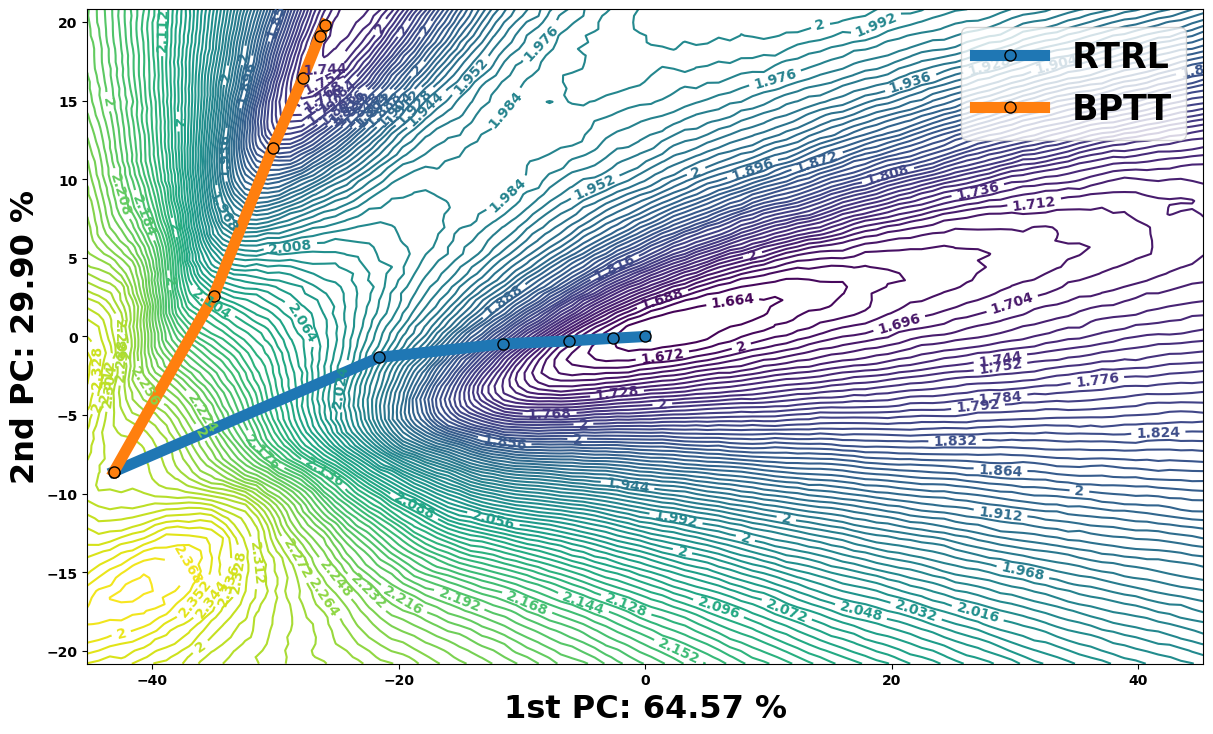

In [ ]:
sl.gen_loss_landscape(get_loss,load_params,6,2)
plt.legend(['OSTL','BPTT','RTRL'][::-1],fontsize=25)
plt.savefig('ll.pdf')